#BUDT 758J - Act12 DL

##Siddhant Soymon

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 837437062896908946
xla_global_id: -1
]


In [16]:
import torch
for index in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_properties(index))

## Read Dataset

In [15]:
# read Fashion MNist dataset
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
data_train = datasets.FashionMNIST(root = 'data', train = True, transform = ToTensor(), download = True)
data_test = datasets.FashionMNIST(root = 'data', train = False, transform = ToTensor(), download = True)
data_train.data.shape, data_train.targets.shape, data_test.data.shape, data_test.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [14]:
# mini batch
from torch.utils.data import DataLoader
batch = 100
load_train = DataLoader(data_train, batch_size = batch, shuffle = False)
load_test = DataLoader(data_test, batch_size = batch, shuffle = False)
len(load_train), len(load_test)

(600, 100)

## Preprocessing

In [17]:
# transformation
in_train = data_train.data / 255.0
in_test = data_test.data / 255.0
in_train.min(), in_train.max(), in_test.min(), in_test.max()

(tensor(0.), tensor(1.), tensor(0.), tensor(1.))

In [18]:
# EDA on out
out_train = data_train.targets
out_test = data_test.targets
# out_train.min(), out_train.max(), out_test.min(), out_test.max()

import numpy as np
np.unique(out_train), np.unique(out_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [19]:
out_train.bincount(), out_test.bincount()

(tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [20]:
# enumerate out classes
data_train.classes, data_test.classes
class_names = data_train.classes

print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Training Set

In [21]:
# define function to display images
import math
import matplotlib.pyplot as plt

def plot(images, labels, predictions=None):
  n_cols = min(10, len(images))
  n_rows = math.ceil(len(images) / n_cols)
  fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols + 3, n_rows + 2))
  if predictions is None:
    predictions = [None] * len(labels)
  for index, (image, label, label_pred) in enumerate(zip(images, labels, predictions)):
    ax = axes.flat[index]
    ax.imshow(image, cmap = plt.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[label])
    if label_pred is not None:
      ax.set_xlabel(class_names[label_pred])

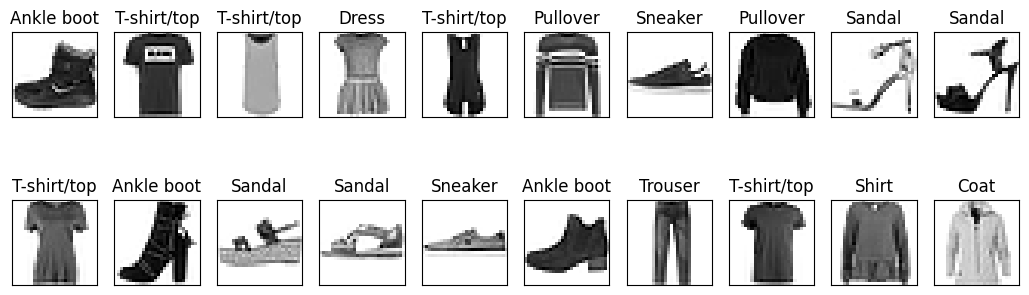

In [22]:
# display first 20 images in train set
plot(in_train[:20], out_train[:20])

## Model in PyTorch

In [12]:
import torch.nn as nn
hidden_size = 500
model = nn.Sequential(
    nn.Linear(28 * 28, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 10),
    nn.Softmax(dim = 1)
)

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
  loss_epoch = 0.0
  for images, labels in load_train:
    optimizer.zero_grad()
    train = images.view(images.shape[0], -1)
    outputs = model(train)
    loss_batch = loss(outputs, labels)
    loss_batch.backward()
    optimizer.step()
    loss_epoch += loss_batch.item()
  total = 0
  correct = 0
  for images, labels in load_train:
    train = images.view(images.shape[0], -1)
    outputs = model(train)
    predictions = torch.max(outputs, 1)[1]
    correct += (predictions == labels).sum()
    total += len(labels)
  print(f'Epoch {epoch + 1}/{epochs} - loss: {loss_epoch/total} - accuracy: {correct/total}')

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=10, bias=True)
  (3): Softmax(dim=1)
)
Epoch 1/10 - loss: 0.016828469532728194 - accuracy: 0.8348000049591064
Epoch 2/10 - loss: 0.016226062818368275 - accuracy: 0.8441166877746582
Epoch 3/10 - loss: 0.016099886343876522 - accuracy: 0.8431833386421204
Epoch 4/10 - loss: 0.01601969297329585 - accuracy: 0.8572999835014343
Epoch 5/10 - loss: 0.015960646990935006 - accuracy: 0.864983320236206
Epoch 6/10 - loss: 0.015908128440380098 - accuracy: 0.8773166537284851
Epoch 7/10 - loss: 0.015872908057769138 - accuracy: 0.87663334608078
Epoch 8/10 - loss: 0.015850637731949488 - accuracy: 0.8818666934967041
Epoch 9/10 - loss: 0.015800812067588172 - accuracy: 0.8827499747276306
Epoch 10/10 - loss: 0.015783003612359365 - accuracy: 0.8815666437149048


# Test Set

In [38]:
#model.evaluate(in_test, out_test)
total = 0
correct = 0
probs_list =  []
preds = []
errors = []

#for images, labels in load_test: #process multiple test data at once
for image, label in zip(in_test, out_test):
  # test = images.view
  test = image.view(1, 28*28)
  with torch.no_grad():
    probs = model(test)
    probs_list.append(probs)
    pred = probs.argmax(1)
    preds.append(pred)
  if pred == label:
    correct += 1
  else:
    errors.append(total)
  total += 1
print(errors)
print(f'Tested {total} images - accuracy: {correct/total}')

[12, 17, 23, 25, 29, 40, 42, 49, 51, 66, 67, 68, 73, 86, 89, 91, 107, 117, 127, 135, 141, 147, 153, 172, 183, 239, 241, 244, 247, 249, 252, 282, 283, 286, 311, 316, 320, 324, 325, 332, 337, 344, 367, 381, 382, 389, 396, 406, 407, 409, 441, 444, 454, 457, 460, 465, 474, 490, 526, 527, 529, 541, 548, 560, 561, 562, 563, 565, 569, 570, 572, 578, 584, 586, 587, 595, 623, 634, 635, 639, 661, 663, 664, 670, 688, 689, 697, 699, 701, 711, 722, 725, 732, 753, 760, 761, 779, 787, 800, 801, 805, 823, 827, 851, 860, 881, 887, 902, 905, 909, 921, 926, 930, 931, 935, 945, 960, 963, 965, 966, 968, 971, 976, 977, 979, 993, 994, 996, 1004, 1005, 1025, 1053, 1055, 1056, 1058, 1065, 1096, 1101, 1104, 1107, 1111, 1121, 1129, 1130, 1131, 1152, 1160, 1162, 1165, 1174, 1197, 1210, 1213, 1223, 1231, 1235, 1254, 1269, 1277, 1280, 1284, 1297, 1300, 1315, 1326, 1329, 1336, 1339, 1342, 1343, 1356, 1374, 1388, 1390, 1396, 1399, 1408, 1449, 1455, 1458, 1462, 1469, 1471, 1481, 1482, 1483, 1487, 1489, 1495, 1496, 150

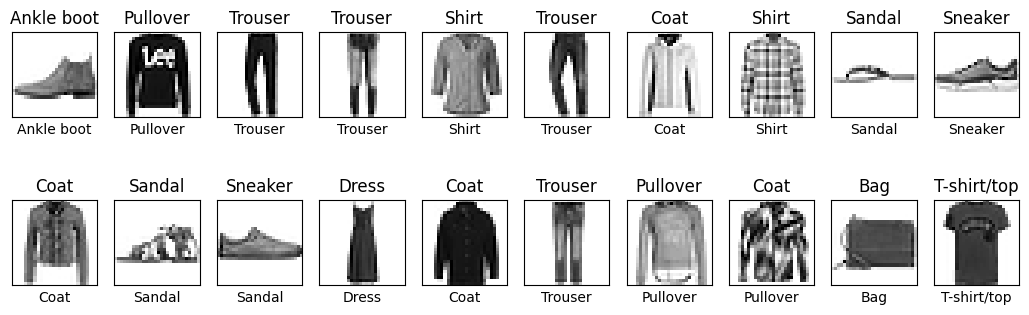

In [39]:
# display first 20 images in test set
plot(in_test[:20], out_test[:20], preds[:20])

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact, Layout
img_idx_slider = widgets.IntSlider(value=0, min=0, max=len(in_test.data) - 1,
                                   description='Image Index',
                                   layout=Layout(width='100%'))
@interact(index=img_idx_slider)
def visualize_prediction(index=0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(in_test.data[index], cmap=plt.cm.binary)
    ax1.set_title(f'Label: {class_names[out_test[index]]}')
    ax1.xaxis.tick_top()
    ax1.set_xlabel(f'Predict: {class_names[preds[index]]}')
    ax1.set_ylabel('Pixel Location Index')
    ax1.set_xticks(range(28))
    ax1.set_yticks(range(28))
    ax1.tick_params(axis='x', labelrotation=90)
    bar = sns.barplot(y=[class_names[ind] for ind in range(10)],
                      x=(probs_list[index][0])*100)
    bar.set_xlim(0, 100)
    bar.set_xlabel('Probability (%)')
    bar.set_ylabel('Prediction Label')
    bar.set_title('Prediction Probabilities')
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='Image Index', layout=Layout(width='100%'), max=9999), Ou…